# What target should we use:
* We could improve this notebook to solve the question with distributions !.
* Imagine that we can perfectly predict a certain target.
* Can we come out with a trading strategy based on this model?
* How often and accurate do we need to be able to do this?
* Lets not think on fees for now - ugly.
* This is the quantity that we want to predict: (S1.pct_change()+1).shift(-2) = S1.pct_change().shift(-2)+1
* Its equivalent to predicting S1.pct_change().shift(-2)

In [73]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [74]:
import pandas as pd
import random
import numpy as np
import datetime as datetime

In [75]:
minutesPerDay = 390

def simulateMultipleStrategies(S1, S2, precision = 80, recall=10, numExperiments=100, sizeExperiment=1*minutesPerDay):
    """ Comment
    """

    S = pd.concat([S1,S2], axis=1).dropna()
    S.columns=['S1', 'S2']
    lenS=len(S)
    experimentStarts = random.choices(range(lenS-sizeExperiment), k=numExperiments)

    endPriceS1=[]
    endPriceS2= []
    endPriceStragegy = []
    
    for es in experimentStarts:
        T1=S[es:es+sizeExperiment]['S1']
        T2=S[es:es+sizeExperiment]['S2']
        end1, end2, endStrategy = simulateStrategyWithNoisyPredictor(T1, T2, precision, recall)
        endPriceS1.append(end1)
        endPriceS2.append(end2)
        endPriceStragegy.append(endStrategy)
    return endPriceS1, endPriceS2, endPriceStragegy


def simulateStrategyWithNoisyPredictor(S1, S2, precision, recall):
    """ Comment
    """
    lenS = len(S1)
    I1 = (1+S1.pct_change()).fillna(1).values
    I2 = (1+S2.pct_change()).fillna(1).values
    Imin = [min(I1[i], I2[i]) for i in range(lenS)]
    Imax = [max(I1[i], I2[i]) for i in range(lenS)]
    
    numPredictions = (lenS*recall)//100
    numCorrectPredictions = (numPredictions*precision)//100
    predictionIndexes = random.sample(range(lenS), numPredictions)
    correctPredictionIndexes = predictionIndexes[:numCorrectPredictions]
    wrongPredictionIndexes = predictionIndexes[numCorrectPredictions:]
    
    Strategy = [I1[i] if random.choice([True,False]) else I2[i] for i in range(lenS)]
    for goodIndex in correctPredictionIndexes: Strategy[goodIndex]=Imax[goodIndex]
    for badIndex in wrongPredictionIndexes: Strategy[badIndex]=Imin[badIndex]
    return np.prod(I1), np.prod(I2), np.prod(Strategy)
    

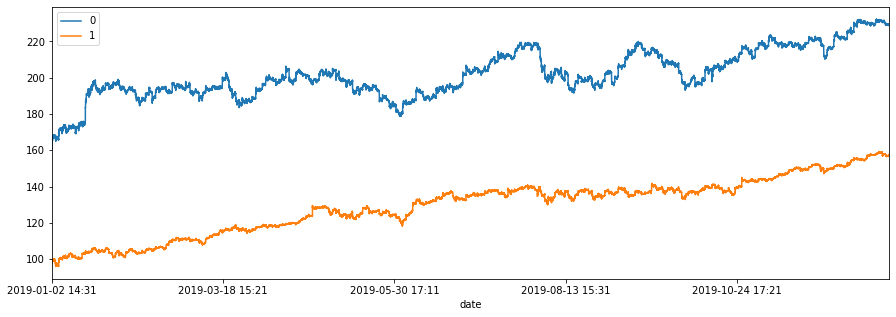

In [76]:
df = pd.read_csv('data/quantopian/minuteIntraday/GS.csv').drop(columns=['volume']).set_index('date')
S1 = df.mean(axis=1)
df = pd.read_csv('data/quantopian/minuteIntraday/MSFT.csv').drop(columns=['volume']).set_index('date')
S2 = df.mean(axis=1)
pd.concat([S1,S2], axis=1).plot(figsize=(15,5))

In [77]:
endStock1, endStock2, endStrategy = simulateMultipleStrategies(S1, S2, precision = 70, recall=10, numExperiments=100, sizeExperiment=20*390)


In [78]:
dr=pd.DataFrame({'endStock1':endStock1, 'endStock2':endStock2, 'endStrategy':endStrategy})

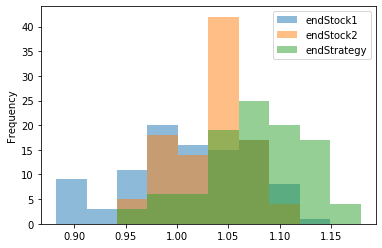

In [79]:
dr.plot.hist(bins=10, alpha=0.5)

In [80]:
dr['bestStock']=dr[['endStock1', 'endStock2']].max(axis=1)

In [81]:
dr['difference']=dr.endStrategy-dr.bestStock

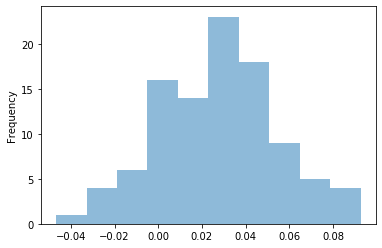

In [82]:
dr.difference.plot.hist(bins=10, alpha=0.5)

In [83]:
dr.difference.describe()

count    100.000000
mean       0.027150
std        0.027086
min       -0.046719
25%        0.007073
50%        0.027739
75%        0.044421
max        0.092648
Name: difference, dtype: float64